# 08-02: Dimensionality Reduction and Principal Component Analysis

*June 12 2024*  

We motivate dimensionality reduction in an illustrative example, where we seek to classify images of hand-written digits. We show how we can reduce the dimensionality of this problem using principal component analysis, i.e. an eigendecomposition of the covariance matrix.

In [28]:
import numpy as np
import scipy.stats
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib.collections import LineCollection

from sklearn.linear_model import LogisticRegression

from sklearn import datasets

from scipy.stats import multivariate_normal
from matplotlib import cm

import sklearn
from sklearn.decomposition import PCA
from sklearn import linear_model

from scipy.linalg import eig

plt.style.use('default')
sns.set_style("whitegrid")

## Principal Component Analysis

We first consider the simple example from the lecture, where we have a data set with two-dimensional features in which only one dimension actually contains information that is relevant for classification.

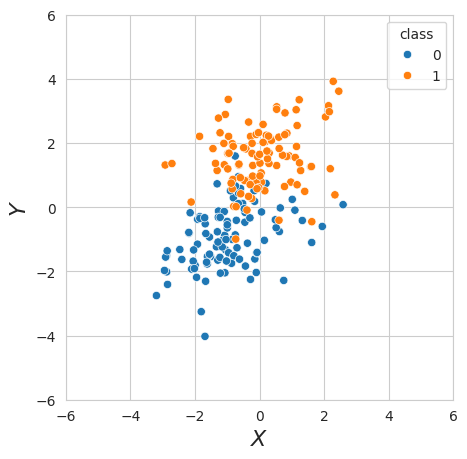

In [29]:
a = multivariate_normal.rvs(mean=[-1,-1], cov=[[1, 0.3],[0.3, 1]], size=100)

b = multivariate_normal.rvs(mean=[0, 1.5], cov=[[1, 0.3],[0.3, 1]], size=100)

data = pd.DataFrame( {'x': a[:,0], 'y': a[:,1], 'class': [0]*100})
data = pd.concat([data, pd.DataFrame( {'x': b[:,0], 'y': b[:,1], 'class': [1]*100})])

fig, ax = plt.subplots(figsize=(5,5))
sns.scatterplot(x='x', y='y', data=data, ax=ax, hue='class')
plt.xlim(-6, 6)
plt.ylim(-6, 6)
plt.xlabel(r'$X$', fontsize=16)
plt.ylabel(r'$Y$', fontsize=16);

We apply principal component analysis, i.e. we first create the covariance matrix and then calculate the eigenvalues and eigenvectors. The eigenvectors are the principal components. Below we plot them as vectors in our data set. We see that the first principal component (orange) is associated with larger variance in the projected (i.e. rotated) data:

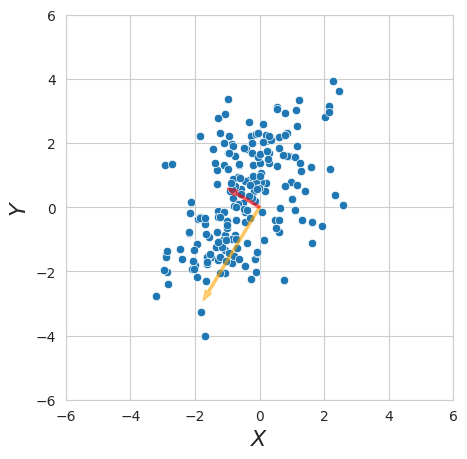

In [30]:
sigma = np.cov(data[['x', 'y']].values.T)
w, v = eig(sigma)
idx = w.argsort()[::-1]   
w = w[idx]
v = v[:,idx]

fig, ax = plt.subplots(figsize=(5,5))
sns.scatterplot(x='x', y='y', data=data, ax=ax)
plt.xlim(-6, 6)
plt.ylim(-6, 6)
plt.xlabel(r'$X$', fontsize=16)
plt.ylabel(r'$Y$', fontsize=16)
plt.arrow(0, 0, np.real(w[0]*v[0,0]), np.real(w[0]*v[1,0]), color='orange', width=0.07, alpha=0.5)
plt.arrow(0, 0, np.real(w[1]*v[0,1]), np.real(w[1]*v[1,1]), color='red', width=0.07, alpha=0.5);

Here the principal components are:

In [31]:
print(v[:,0])
print(v[:,1])

[-0.51441365 -0.85754218]
[-0.85754218  0.51441365]


We can use the matrix consisting of eigenvectors to rotate the coordinate system in which our data are represented. In the rotated data, the x-axis captures the most variance:

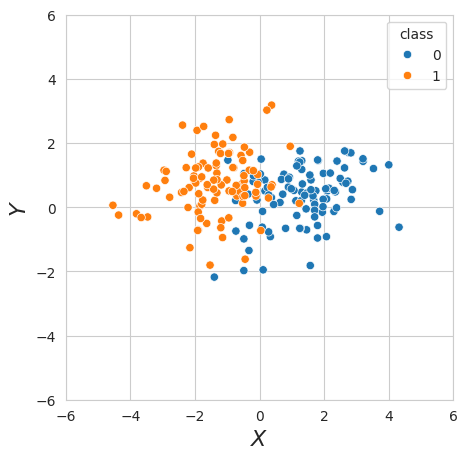

In [32]:
t = np.dot(data[['x', 'y']].values, v)
transformed_data = pd.DataFrame( {'x' : t[:,0], 'y' : t[:,1], 'class': data['class'] })

fig, ax = plt.subplots(figsize=(5,5))
sns.scatterplot(x='x', y='y', data=transformed_data, ax=ax, hue='class')
plt.xlim(-6, 6)
plt.ylim(-6, 6)
plt.xlabel(r'$X$', fontsize=16)
plt.ylabel(r'$Y$', fontsize=16);

We can use the associated eigenvalues to calculate the absolute value and the fraction of variance that is explained by the associated principal components:

In [33]:
print(np.real(w[0]))
np.real(w[0]/np.sum(w))

3.0786361133436024


np.float64(0.7827349344794184)

In [34]:
print(np.real(w[1]))
np.real(w[1]/np.sum(w))

0.8545422561527616


np.float64(0.21726506552058153)

## Principal Component Analysis in sklearn

We can use `sklearn` to calculate principal components. The class `PCA` uses the usual `fit` interface.

In [35]:
pca = PCA()
pca = pca.fit(data[['x', 'y']])
print(pca.components_[0])
print(pca.components_[1]) 

[0.51441365 0.85754218]
[ 0.85754218 -0.51441365]


In [36]:
print(pca.explained_variance_)

[3.07863611 0.85454226]


To transform the data we can call `fit_transform`:

In [37]:
t = pca.fit_transform(data[['x', 'y']])
transformed_data = pd.DataFrame( {'x' : t[:,0], 'y' : t[:,1], 'class': data['class'] })

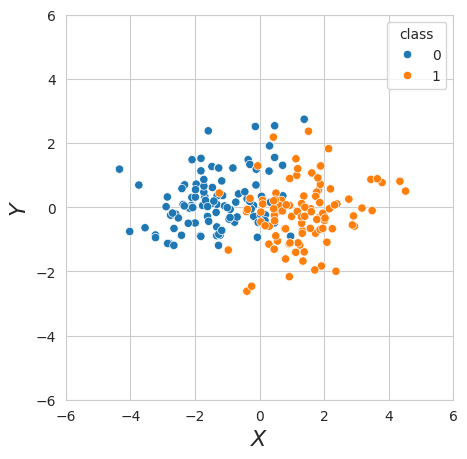

In [38]:
fig, ax = plt.subplots(figsize=(5,5))
sns.scatterplot(x = 'x', y = 'y', ax=ax, hue='class', data=transformed_data)
plt.xlim(-6, 6)
plt.ylim(-6, 6)
plt.xlabel(r'$X$', fontsize=16)
plt.ylabel(r'$Y$', fontsize=16);

We can now apply logistic regression. We start by using both dimensions in the original data:

In [39]:
logreg = LogisticRegression(solver='lbfgs')

logreg.fit(data[['x', 'y']], data['class'])
data['predicted'] = logreg.predict(data[['x', 'y']])
sklearn.metrics.roc_auc_score(data[['class']], data[['predicted']])

np.float64(0.9049999999999999)

In [40]:
logreg = LogisticRegression(solver='lbfgs')

logreg.fit(data[['x']], data['class'])
data['predicted'] = logreg.predict(data[['x']])
sklearn.metrics.roc_auc_score(data[['class']], data[['predicted']])

np.float64(0.715)

In [41]:
logreg = LogisticRegression(solver='lbfgs')

logreg.fit(transformed_data[['x']], transformed_data['class'])
transformed_data['predicted'] = logreg.predict(transformed_data[['x']])
sklearn.metrics.roc_auc_score(transformed_data[['class']], transformed_data[['predicted']])

np.float64(0.89)

## Application to image classification

We finally show how we can apply PCA to an image classification problem. We will use the `digits` data set that is included in `sklearn`. We first define a function that allows us to plot an image using `matplotlib`.

In [42]:
def plotImage(img, f = None):
    font = {'color':  'red',
        'weight': 'bold',
        'size': 16,
        }    
    plt.imshow(img, cmap=plt.cm.gray_r, interpolation='none')    
    plt.xticks(range(8))
    plt.yticks(range(8))
    if type(f) is np.ndarray:
        str_label = '(' + str(np.round(f[1], 2)) + ', ' + str(np.round(f[0], 2)) + ')'
        plt.scatter(f[1], f[0], 280, 'red', 'x')
        plt.axhline(y=f[0], color='red', linewidth=3)
        plt.axvline(x=f[1], color='red', linewidth=3)
        plt.text(3, 4, str_label, fontdict=font)
    plt.grid()
    plt.tick_params(axis='both', which='major', labelsize=18)

[[ 0.  5. 12. 13. 16. 16.  2.  0.]
 [ 0. 11. 16. 15.  8.  4.  0.  0.]
 [ 0.  8. 14. 11.  1.  0.  0.  0.]
 [ 0.  8. 16. 16. 14.  0.  0.  0.]
 [ 0.  1.  6.  6. 16.  0.  0.  0.]
 [ 0.  0.  0.  5. 16.  3.  0.  0.]
 [ 0.  1.  5. 15. 13.  0.  0.  0.]
 [ 0.  4. 15. 16.  2.  0.  0.  0.]]


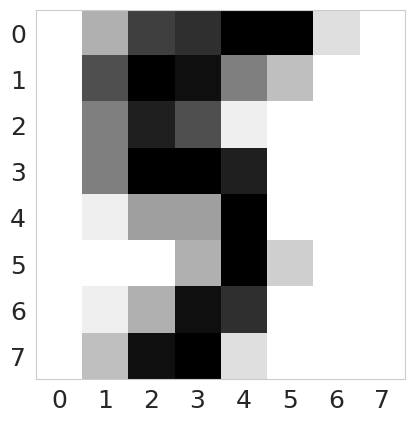

In [43]:
n=1500
digits = datasets.load_digits()
print(digits.images[15])
plotImage(digits.images[15])

The target dictionary contains the numbers shown in the images:

In [44]:
print(digits.target[15])

5


In [55]:
images_data = [
    {j: digits.images[i].ravel()[j] for j in range(64)}
    for i in range(n)
]
images_data

[{0: np.float64(0.0),
  1: np.float64(0.0),
  2: np.float64(5.0),
  3: np.float64(13.0),
  4: np.float64(9.0),
  5: np.float64(1.0),
  6: np.float64(0.0),
  7: np.float64(0.0),
  8: np.float64(0.0),
  9: np.float64(0.0),
  10: np.float64(13.0),
  11: np.float64(15.0),
  12: np.float64(10.0),
  13: np.float64(15.0),
  14: np.float64(5.0),
  15: np.float64(0.0),
  16: np.float64(0.0),
  17: np.float64(3.0),
  18: np.float64(15.0),
  19: np.float64(2.0),
  20: np.float64(0.0),
  21: np.float64(11.0),
  22: np.float64(8.0),
  23: np.float64(0.0),
  24: np.float64(0.0),
  25: np.float64(4.0),
  26: np.float64(12.0),
  27: np.float64(0.0),
  28: np.float64(0.0),
  29: np.float64(8.0),
  30: np.float64(8.0),
  31: np.float64(0.0),
  32: np.float64(0.0),
  33: np.float64(5.0),
  34: np.float64(8.0),
  35: np.float64(0.0),
  36: np.float64(0.0),
  37: np.float64(9.0),
  38: np.float64(8.0),
  39: np.float64(0.0),
  40: np.float64(0.0),
  41: np.float64(4.0),
  42: np.float64(11.0),
  43: np.flo

In [58]:
image_data = pd.DataFrame.from_dict(images_data)
image_data.head()

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,...,9.0,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0


We apply PCA and transform the data

In [59]:
sigma = np.cov(image_data.values.T)
w, v = eig(sigma)
idx = w.argsort()[::-1]
w = w[idx]
v = v[:,idx]

In [65]:
x = np.dot(v.T, image_data.values.T)
transformed_image_data = pd.DataFrame()
for i in range(64):
    transformed_image_data[str(i)] = x[i].astype(float)
transformed_image_data['digit'] = [digits.target[i] for i in range(n)]

We can now fit a logistic regression model with an increasing number of features, where the feature dimensions have been constructed based on the principal components:

In [66]:
logreg = LogisticRegression()

num_comps = range(64)
accs = []

for i in range(64):
    features = [ str(j) for j in range(i+1) ]
    # Create instance of Logistic Regression Classifier and fit the data.
    logreg.fit(transformed_image_data[features], transformed_image_data['digit'])
    transformed_image_data['predicted'] = logreg.predict(transformed_image_data[features])
    accs.append(sklearn.metrics.balanced_accuracy_score(transformed_image_data[['digit']], transformed_image_data[['predicted']]))

/home/jovyan/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/jovyan/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

Text(0, 0.5, 'balanced accuracy score')

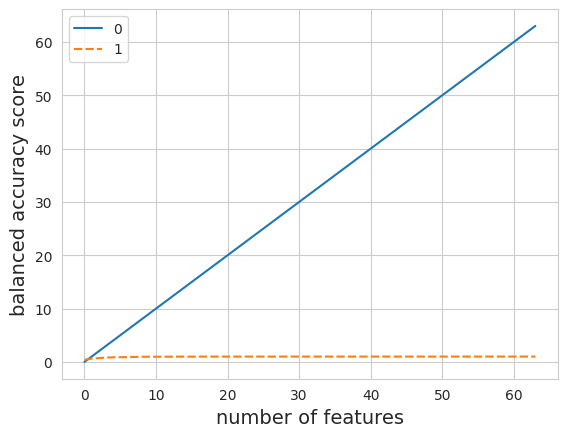

In [68]:
sns.lineplot(data=(num_comps, accs))
plt.xlabel('number of features', fontsize=14)
plt.ylabel('balanced accuracy score', fontsize=14)

## Eigenimage-based image compression

As a bonus, we show how we can reconstruct original image data based on the first principal components.  

In [69]:
eigenimage_1 = v[:,0].reshape(8,-1).astype(float)
eigenimage_2 = v[:,1].reshape(8,-1).astype(float)
eigenimage_3 = v[:,2].reshape(8,-1).astype(float)
eigenimage_4 = v[:,3].reshape(8,-1).astype(float)
eigenimage_5 = v[:,4].reshape(8,-1).astype(float)

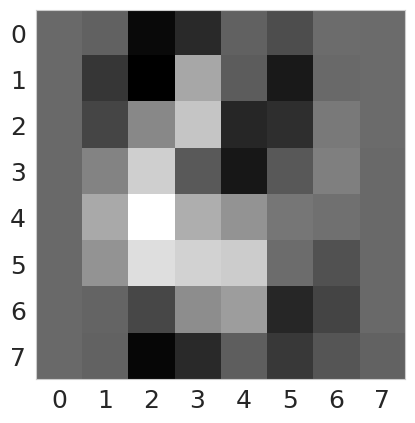

In [70]:
plotImage(eigenimage_1)

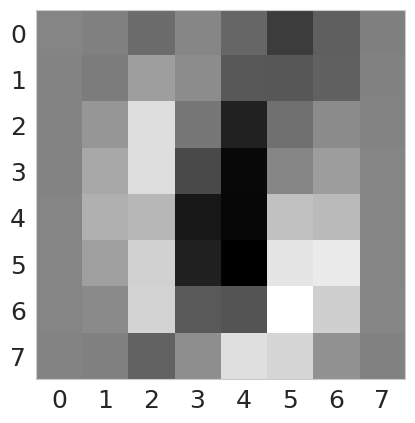

In [71]:
plotImage(eigenimage_2)

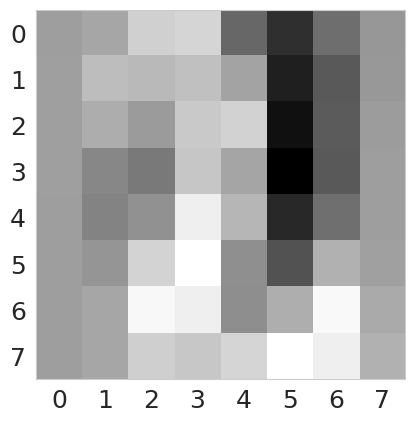

In [72]:
plotImage(eigenimage_3)

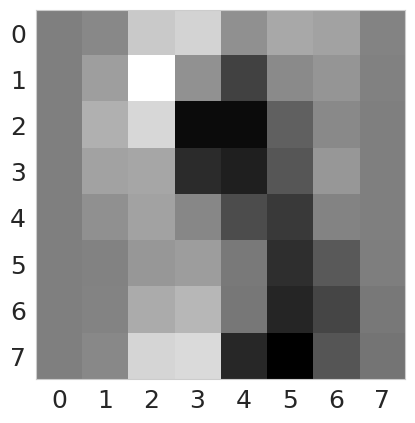

In [73]:
plotImage(eigenimage_4)

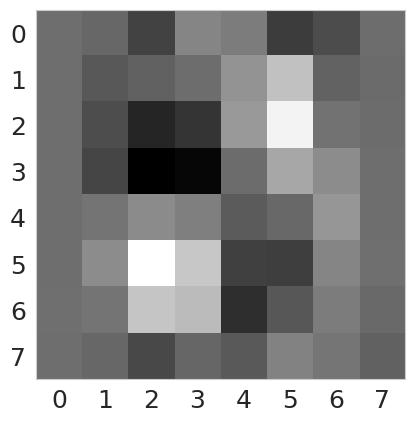

In [74]:
plotImage(eigenimage_5)

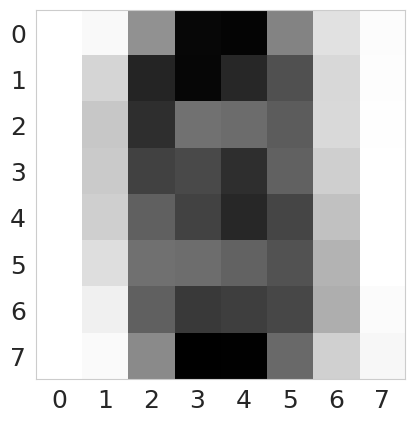

In [75]:
mean_image = image_data.mean().values.reshape(8,-1).astype(float)
plotImage(mean_image)

In [76]:
def recoverImage(k, image_indx):
    mean_img = image_data.mean().values
    recovered_data = np.zeros(64)
    for i in range(k):
        recovered_data += (np.dot(digits.images[image_indx].ravel().T, v[:,i]) - np.dot(mean_img.T, v[:,i]))* v[:,i]
    return recovered_data+mean_img

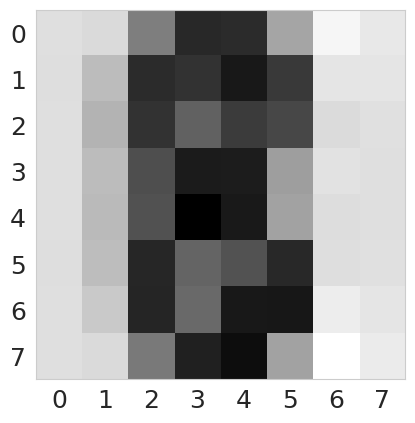

In [77]:
recovered_data = recoverImage(12, 138)
plotImage(recovered_data.reshape(8,-1).astype(float))

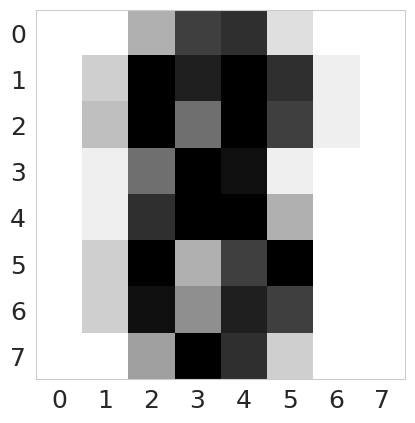

In [78]:
plotImage(digits.images[138])